# Árvore de Regressão

## Import

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import tree

## Objetivo

### 1. intuição: Maximizando a gorjeta do garçom<a name="1"></a>

Vamos ilustrar essa seção com o problema da gorjeta do garçom. Vamos montar uma árvore que tente explicar a variabilidade das gorjetas com base em variáveis que permitam montar uma estratégia para o garçom (assumindo que ele tenha uma certa liberdade pra escolher a mesa e o horário de trabalho). O sexo pode entrar como uma variável de controle. Para sexos diferentes podem fazer sentido estratégias diferentes - ou pelo menos pode-se conhecer uma eventual vantagem ou desvantagem na largada.

Note que o valor da conta não se conhece antes de escolher a mesa, portanto não é uma boa variável para se colocar no modelo com esta finalidade.

Quais variáveis mais discriminam a gorjeta? Pra responder a esta pergunta montamos um painelzinho abaixo.

## Dataframe

In [74]:
tips = sns.load_dataset("tips")
tips['tip_pct'] = tips['tip'] / (tips['total_bill'] - tips['tip'])
tips.head()

,total_bill,tip,sex,smoker,day,time,size,tip_pct
0,16.99,1.01,Female,No,Sun,Dinner,2,0.063204
1,10.34,1.66,Male,No,Sun,Dinner,3,0.191244
2,21.01,3.50,Male,No,Sun,Dinner,3,0.199886
3,23.68,3.31,Male,No,Sun,Dinner,2,0.162494
4,24.59,3.61,Female,No,Sun,Dinner,4,0.172069


## Medidas de Impureza

#### Medidas de impureza

O que queremos fazer aqui é **explicar a variabilidade** da gorjeta com base nas variáveis que temos disponíveis.A medida mais popular de "impureza" da árvore é o **erro quadrático médio** (MSE - *mean square error* em ingês).

MSE = $\displaystyle\frac{1}{n}\sum_{ x \in c }(x_i - \hat{x})^2 $


C:\Users\Gabriel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
C:\Users\Gabriel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
C:\Users\Gabriel\anaconda3\Lib\site-packages\seaborn\categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 0.0, 0.0), (1.0, 0.0, 0.0), (1.0, 0.0, 0.0), (1.0, 0.0, 0.0), (1.0, 0.0, 0.0), (1.0, 0.0, 0.0)]) for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


Text(0.5, 0, 'Tamanho da mesa')

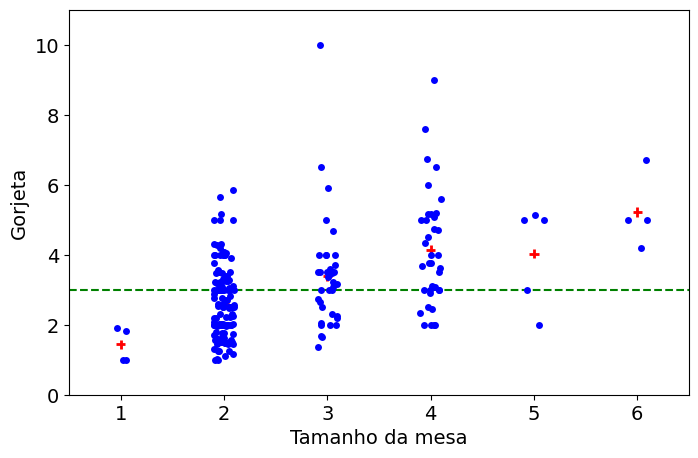

In [75]:
plt.rc('figure', figsize=(8, 5))

ax1 = sns.stripplot(x="size", y="tip", data=tips, color='blue')
ax1.set(ylim=(0, 11))
ax1.axhline(tips['tip'].mean(), ls='--', color = 'green')

ax1.set(ylim=(0, 11))
ax1 = sns.pointplot(x="size", y="tip", data=tips, color='red', errorbar=None, linestyles='', markers='+')

ax1.set_ylabel("Gorjeta")
ax1.set_xlabel("Tamanho da mesa")

A célula abaixo calcula o erro quadrático médio para cada possível quebra da árvore. Não precisa se preocupar tanto com esse código, já que o scikitlearn já faz essa conta pra nós. Aqui está mais para ilustrarmos como o algoritmo vai fazer para procurar a melhor quebra.

In [76]:
quebra = 2

EQM = []
for quebra in range(tips['size'].max() + 1):
    grupos = pd.cut(tips['size']
                    , bins = [-1, quebra, 99]
                    , labels = ['0 a ' + str(quebra), str(quebra) + ' ou mais'])

    tips_ = tips.copy()
    tips_['grupo'] = grupos

    tips_ = tips_.merge(tips_[['tip', 'grupo']].groupby('grupo').mean()
                        , on = 'grupo'
                        , how = 'left')

    # tips_
    tips_['EQ'] = (tips_['tip_x'] - tips_['tip_y'])**2
    EQM.append(tips_['EQ'].mean())


["{:5.2f}".format(x) for x in EQM]


C:\Users\Gabriel\AppData\Local\Temp\ipykernel_15052\1759459922.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Gabriel\AppData\Local\Temp\ipykernel_15052\1759459922.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Gabriel\AppData\Local\Temp\ipykernel_15052\1759459922.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Gabriel\AppData\Local\Temp\ipykernel_15052\1759459922.py:12: FutureWarnin

[' 1.91', ' 1.87', ' 1.53', ' 1.56', ' 1.81', ' 1.82', ' 1.91']

* Vemos abaixo que o menor EQM está na quebra **size > 2**;
* E será este EQM que iremos escolher como valor de quebra.

Text(0.5, 0, 'Tamanho da mesa < X')

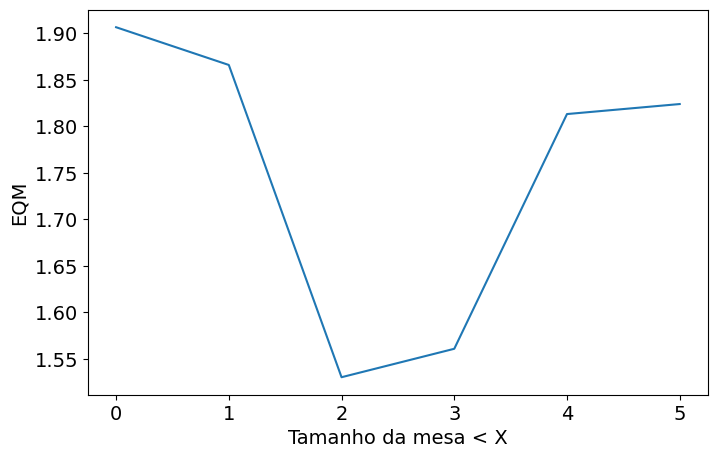

In [77]:
fig = plt.figure()

plt.plot(EQM[0:6])
plt.ylabel("EQM")
plt.xlabel("Tamanho da mesa < X")

## Separando em Treino e Teste

In [78]:
X = tips.drop(columns = ['total_bill', 'tip', 'tip_pct'], axis = 1).copy()
X = pd.get_dummies(X, drop_first = True)

In [79]:
y =  tips['tip']
y.head()

0    1.01
1    1.66
2    3.50
3    3.31
4    3.61
Name: tip, dtype: float64

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2360873)

## Pre-Prunning

* Analisar o MSE de acordo com os diferentes valores de Pre-Prunning

In [81]:
regr = DecisionTreeRegressor(max_depth=3, min_samples_leaf=10)
regr.fit(X_train, y_train)
mse = regr.score(X_test, y_test)
mse

0.2392376384366277

n_minimo,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
profundidade,,,,,,,,,,,,,,,,,,,
2,0.253436,0.253436,0.253436,0.259370,0.259370,0.259370,0.259370,0.259370,0.259370,0.259370,0.259370,0.259370,0.259370,0.259370,0.259370,0.259370,0.259370,0.259370,0.259370
3,0.248468,0.248468,0.248468,0.239238,0.239238,0.239238,0.239238,0.239238,0.239238,0.239238,0.245591,0.251084,0.251084,0.258377,0.258377,0.257513,0.257513,0.257513,0.257513
4,0.245427,0.251741,0.251741,0.253258,0.240488,0.241253,0.241253,0.241253,0.241253,0.241253,0.232992,0.237770,0.237770,0.245063,0.246917,0.246054,0.246054,0.246054,0.246054
5,0.286381,0.303885,0.303885,0.222814,0.210044,0.236062,0.236062,0.236062,0.236062,0.236062,0.228870,0.237770,0.237770,0.245063,0.246917,0.246054,0.246054,0.246054,0.246054
6,0.256097,0.286307,0.286307,0.199597,0.179660,0.212844,0.221031,0.227590,0.227590,0.227590,0.228870,0.237770,0.237770,0.245063,0.246917,0.246054,0.246054,0.246054,0.246054
7,0.226581,0.264802,0.264299,0.192430,0.179660,0.205677,0.221031,0.221031,0.227590,0.227590,0.228870,0.237770,0.237770,0.245063,0.246917,0.246054,0.246054,0.246054,0.246054
8,0.219033,0.257254,0.264299,0.192430,0.186827,0.205677,0.221031,0.227590,0.221031,0.227590,0.228870,0.237770,0.237770,0.245063,0.246917,0.246054,0.246054,0.246054,0.246054
9,0.226581,0.264802,0.264299,0.199597,0.179660,0.212844,0.221031,0.227590,0.221031,0.227590,0.228870,0.237770,0.237770,0.245063,0.246917,0.246054,0.246054,0.246054,0.246054
10,0.219033,0.257254,0.264299,0.192430,0.186827,0.212844,0.221031,0.221031,0.221031,0.227590,0.228870,0.237770,0.237770,0.245063,0.246917,0.246054,0.246054,0.246054,0.246054


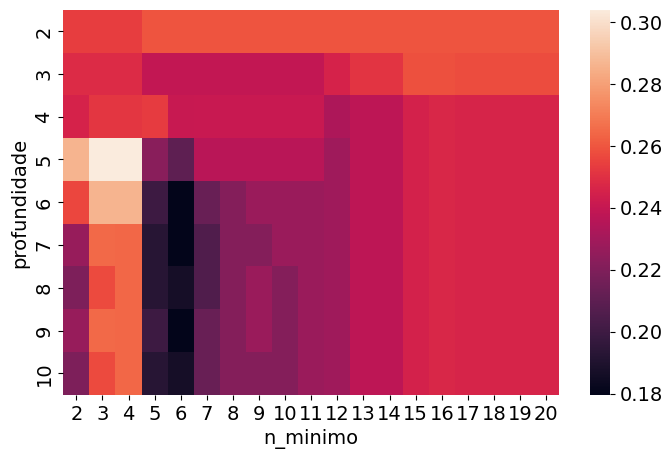

In [82]:
mses = []
ind_i = []
ind_j = []

for i in range(2, 11):
    for j in range(2, 21):
        regr = DecisionTreeRegressor(max_depth=i, min_samples_leaf=j)
        regr.fit(X_train, y_train)
        mse = regr.score(X_test, y_test)
        mses.append(mse)
        ind_i.append(i)
        ind_j.append(j)
        
df_mse = pd.DataFrame({'mses':mses, 'profundidade':ind_i, 'n_minimo':ind_j})
sns.heatmap(df_mse.pivot(index='profundidade', columns='n_minimo', values='mses'))
df_mse.pivot(index='profundidade', columns='n_minimo', values='mses')

## Post-Pruning

* `Impurities:` Representa os valores de MSE.

In [83]:
regr = DecisionTreeRegressor(max_depth=10, min_samples_leaf=5, random_state=100)
path = regr.cost_complexity_pruning_path(X_train, y_train)
path

{'ccp_alphas': array([0.00000000e+00, 2.34900776e-06, 3.51434426e-04, 5.81445604e-04,
        1.13817600e-03, 4.72292297e-03, 7.64135749e-03, 1.27627166e-02,
        1.32813661e-02, 1.54579755e-02, 2.21410250e-02, 2.25814329e-02,
        2.31988019e-02, 3.14966462e-02, 4.10774125e-01]),
 'impurities': array([1.416588  , 1.41659035, 1.41694179, 1.41752323, 1.41866141,
        1.4375531 , 1.44519446, 1.45795718, 1.47123854, 1.48669652,
        1.50883754, 1.55400041, 1.57719921, 1.6401925 , 2.05096663])}

* Abaixo é visto que com o ccp_alpha = 0 obtem-se o menor número de MSE.

Text(0, 0.5, 'Impureza total das folhas')

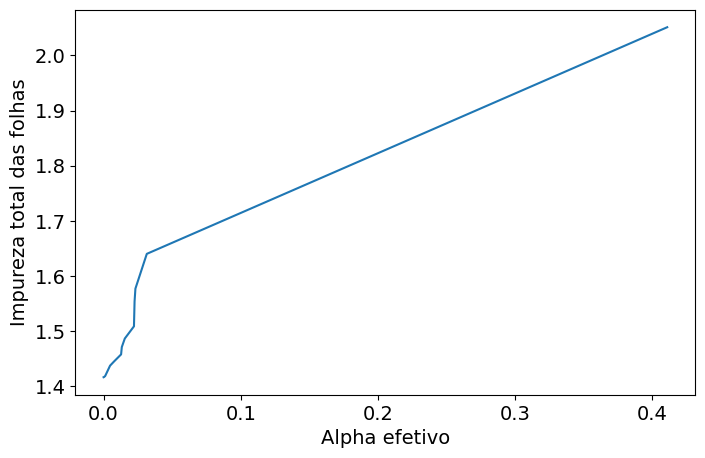

In [84]:
ccp_alphas, impurities = path.ccp_alphas, path.impurities

plt.plot(ccp_alphas, impurities)
plt.xlabel("Alpha efetivo")
plt.ylabel("Impureza total das folhas")

In [85]:
regrs = []

for ccp_alpha in ccp_alphas:
    regr = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
    regr.fit(X_train, y_train)
    regrs.append(regr)

* Abaixo é visto que para um ccp alpha = 0 a profundidade é maior.

Text(0, 0.5, 'Profundidade da árvore')

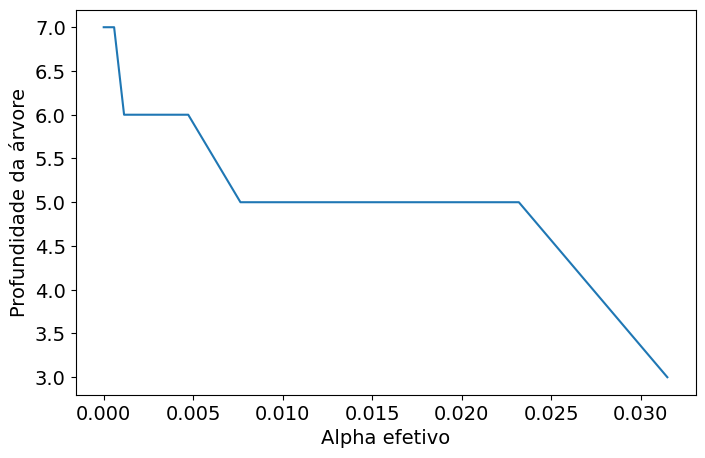

In [86]:
tree_depths = [regr.tree_.max_depth for regr in regrs]
plt.plot(ccp_alphas[:-1], tree_depths[:-1])
plt.xlabel("Alpha efetivo")
plt.ylabel("Profundidade da árvore")

* Há um ponto de equilíbrio entre a base de treino e de teste quando o alpha é 0.005 (MSE=1.3);
* O menor MSE(<1.1) é para um alpha em torno de 0.01;
* Treino: Maior o alpha, maior o MSE;
* Teste: Maior o alpha, menor o MSE.

* `CONCLUSÃO:` ESCOLHER ALPHA=0.010 PARA OBTER O MENOR MSE POSSÍVEL.

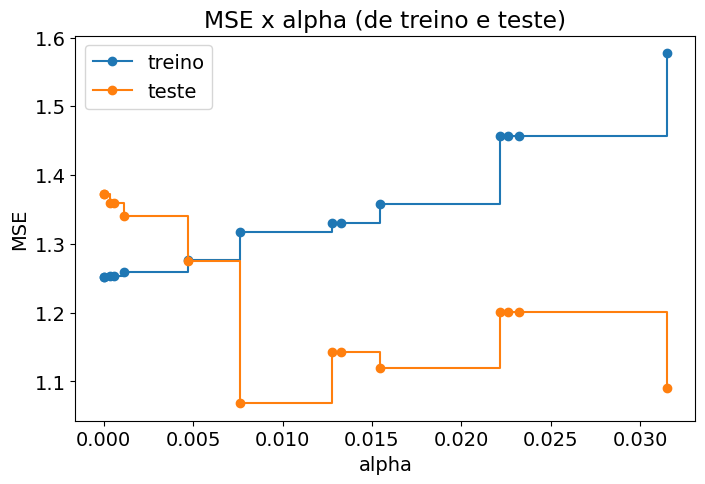

In [87]:
train_scores = [mean_squared_error(y_train , regr.predict(X_train)) for regr in regrs]
test_scores  = [mean_squared_error(y_test  , regr.predict(X_test )) for regr in regrs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("MSE")
ax.set_title("MSE x alpha (de treino e teste)")
ax.plot(ccp_alphas[:-1], train_scores[:-1], marker='o', label="treino",
        drawstyle="steps-post")
ax.plot(ccp_alphas[:-1], test_scores[:-1], marker='o', label="teste",
        drawstyle="steps-post")
ax.legend()
plt.show()

## Visualizando árvore

In [88]:
mse1 = regr_1.score(X_train, y_train)
mse2 = regr_2.score(X_train, y_train)

print(f'mse1 (Profundidade = 2): {round((mse1), 2)}')
print(f'mse2 (Profundidade = 8): {round((mse2), 2)}')

mse1 (Profundidade = 2): 0.23
mse2 (Profundidade = 8): 0.39


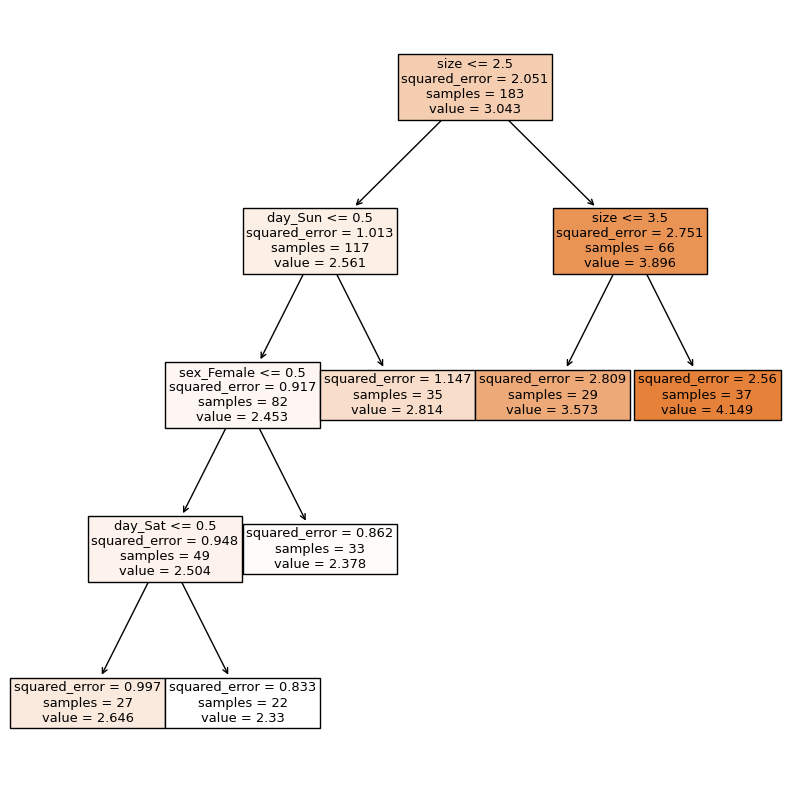

In [89]:
plt.rc('figure', figsize=(10, 10))
tp = tree.plot_tree(regr_1, 
                    feature_names=X.columns.to_list(),  
                    filled=True) 

In [90]:
representacao_textual = tree.export_text(regr_1)
print(representacao_textual)

|--- feature_0 <= 2.50
|   |--- feature_5 <= 0.50
|   |   |--- feature_1 <= 0.50
|   |   |   |--- feature_4 <= 0.50
|   |   |   |   |--- value: [2.65]
|   |   |   |--- feature_4 >  0.50
|   |   |   |   |--- value: [2.33]
|   |   |--- feature_1 >  0.50
|   |   |   |--- value: [2.38]
|   |--- feature_5 >  0.50
|   |   |--- value: [2.81]
|--- feature_0 >  2.50
|   |--- feature_0 <= 3.50
|   |   |--- value: [3.57]
|   |--- feature_0 >  3.50
|   |   |--- value: [4.15]



#### V isualização Personalizada

* Verificar documentação, pois, o código abaixo está desatualizado:

In [ ]:
# import graphviz
# # DOT data
# dot_data = tree.export_graphviz(regr_2, out_file=None, 
#                                 feature_names=X.columns,
#                                 filled=True)

# # Draw graph
# graph = graphviz.Source(dot_data, format="png") 
# graph

In [ ]:
# plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
# plt.rcParams.update({'font.size': 14})

# from dtreeviz.trees import dtreeviz # remember to load the package

# dtreeviz(regr_1, X, y,
#                 target_name="target",
#                 feature_names=X.columns)